In [12]:
!pip3 install numpyro


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


sample: 100%|█████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1323.48it/s, 7 steps of size 8.02e-01. acc. prob=0.92]


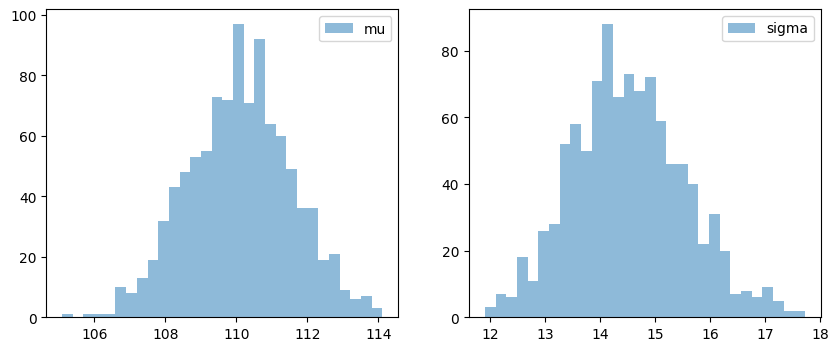

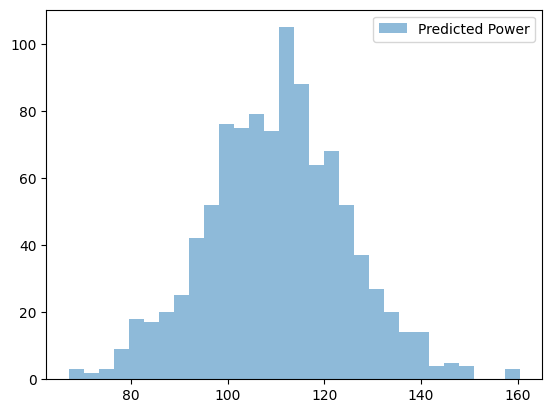

In [15]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Simulated data
user_power = np.random.normal(loc=110, scale=15, size=100)

# Define the model
def model(user_power=None):
    mu = numpyro.sample('mu', dist.Normal(100, 20))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    with numpyro.plate('data', len(user_power) if user_power is not None else 1):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=user_power)

# Run inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
mcmc.run(jax.random.PRNGKey(0), user_power=jnp.array(user_power))

# Extract results
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples['mu']
sigma_samples = posterior_samples['sigma']

# Plot posterior distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, alpha=0.5, label='mu')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, alpha=0.5, label='sigma')
plt.legend()
plt.show()

# Use the posterior for prediction
predictive = Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1))
predicted_power = predictions['obs']

# Plot predicted power
plt.hist(predicted_power.flatten(), bins=30, alpha=0.5, label='Predicted Power')
plt.legend()
plt.show()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|█████████████████████████████████████████████████████| 1500/1500 [02:48<00:00,  8.91it/s, 127 steps of size 1.28e-01. acc. prob=0.88]


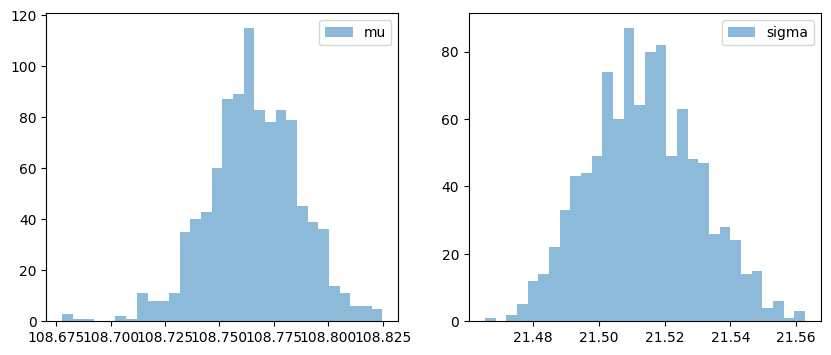

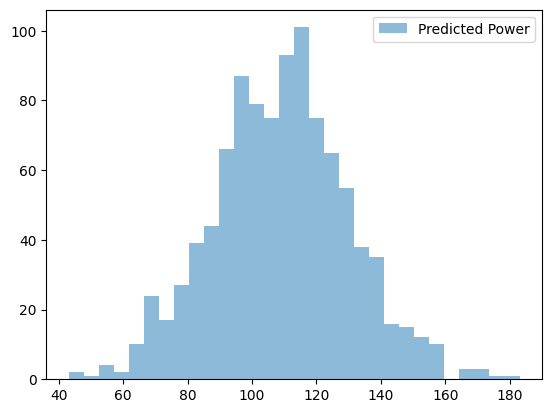

In [1]:
import pandas as pd
import numpy as np
import os
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

# Directory containing the CSV files
data_directory = "/scratch/cognit/filtered_workloads"

# List all CSV files in the directory
all_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]

# Select the first 10 files (or use random.sample to randomly select 10 files)
selected_files = all_files[:3]

# Load and concatenate the selected CSV files
data_frames = []
for file_name in selected_files:
    df = pd.read_csv(os.path.join(data_directory, file_name))
    data_frames.append(df)

# Combine all data frames into one
all_data = pd.concat(data_frames)

# Filter the necessary columns and preprocess
power_data = all_data[['timestamp', 'power_draw_W', 'id_user']]

# Convert to numpy array
power_draw = power_data['power_draw_W'].values

# Define the model
def model(power_draw=None):
    # Hyperpriors
    mu_mu = numpyro.sample('mu_mu', dist.Normal(100, 20))
    sigma_mu = numpyro.sample('sigma_mu', dist.HalfNormal(10))
    
    mu = numpyro.sample('mu', dist.Normal(mu_mu, sigma_mu))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    
    with numpyro.plate('data', len(power_draw) if power_draw is not None else 1):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=power_draw)

# Run inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
mcmc.run(jax.random.PRNGKey(0), power_draw=jnp.array(power_draw))

# Extract results
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples['mu']
sigma_samples = posterior_samples['sigma']

# Plot posterior distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, alpha=0.5, label='mu')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, alpha=0.5, label='sigma')
plt.legend()
plt.show()

# Use the posterior for prediction
predictive = Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1))
predicted_power = predictions['obs']

# Plot predicted power
plt.hist(predicted_power.flatten(), bins=30, alpha=0.5, label='Predicted Power')
plt.legend()
plt.show()


   file_id         id_user   avg_power  avg_timelimit
0        0  72781180556911   25.523394         1440.0
1        1   5042570016904   55.724961           45.0
2        2  81181317558932  204.327981         1440.0
3        3  50123227738265   53.951292         4320.0
4        4  47316339001413  162.722343        11520.0


sample: 100%|██████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 765.80it/s, 7 steps of size 3.81e-01. acc. prob=0.74]


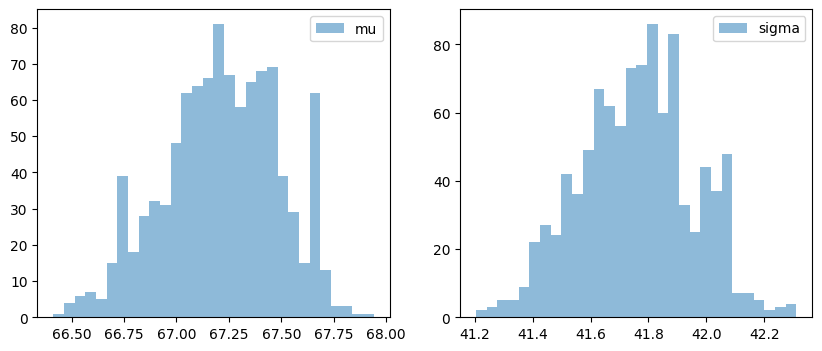

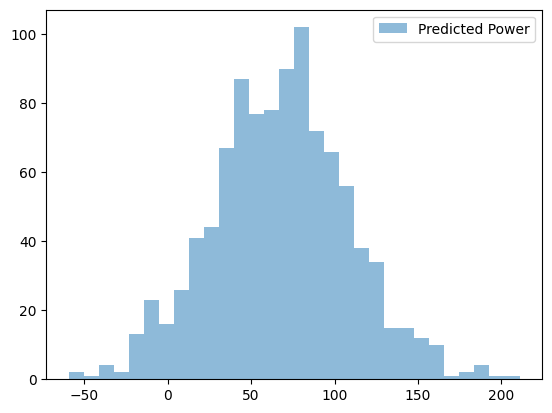

In [2]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

# Path to the summary CSV file
summary_file_path = "/scratch/cognit/workload_summary.csv"

# Load the summary CSV file
summary_data = pd.read_csv(summary_file_path)

# Display first few rows
print(summary_data.head())

# Filter the necessary columns and preprocess
power_data = summary_data[['id_user', 'avg_power', 'avg_timelimit']]

# Convert to numpy array
avg_power = power_data['avg_power'].values

# Define the model
def model(power_draw=None):
    # Hyperpriors
    mu_mu = numpyro.sample('mu_mu', dist.Normal(100, 20))
    sigma_mu = numpyro.sample('sigma_mu', dist.HalfNormal(10))
    
    mu = numpyro.sample('mu', dist.Normal(mu_mu, sigma_mu))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    
    with numpyro.plate('data', len(power_draw) if power_draw is not None else 1):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=power_draw)

# Run inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
mcmc.run(jax.random.PRNGKey(0), power_draw=jnp.array(avg_power))

# Extract results
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples['mu']
sigma_samples = posterior_samples['sigma']

# Plot posterior distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, alpha=0.5, label='mu')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, alpha=0.5, label='sigma')
plt.legend()
plt.show()

# Use the posterior for prediction
predictive = Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1))
predicted_power = predictions['obs']

# Plot predicted power
plt.hist(predicted_power.flatten(), bins=30, alpha=0.5, label='Predicted Power')
plt.legend()
plt.show()


   file_id         id_user   avg_power  avg_timelimit
0        0  72781180556911   25.523394         1440.0
1        1   5042570016904   55.724961           45.0
2        2  81181317558932  204.327981         1440.0
3        3  50123227738265   53.951292         4320.0
4        4  47316339001413  162.722343        11520.0


sample: 100%|█████████████████████████████████████████████████████| 1500/1500 [00:09<00:00, 166.60it/s, 15 steps of size 3.16e-01. acc. prob=0.89]


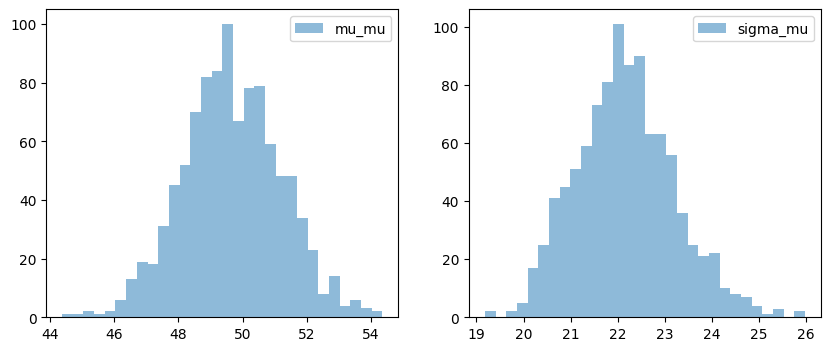

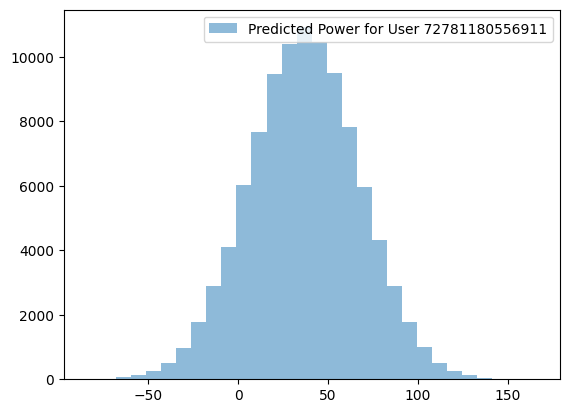

In [3]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

# Path to the summary CSV file
summary_file_path = "/scratch/cognit/workload_summary.csv"

# Load the summary CSV file
summary_data = pd.read_csv(summary_file_path)

# Display first few rows
print(summary_data.head())

# Filter the necessary columns and preprocess
power_data = summary_data[['id_user', 'avg_power', 'avg_timelimit']]

# Convert to numpy array
user_ids = power_data['id_user'].values
avg_power = power_data['avg_power'].values

# Encode user IDs as integers for indexing
unique_user_ids, user_idx = np.unique(user_ids, return_inverse=True)

# Define the hierarchical model
def hierarchical_model(user_idx=None, power_draw=None):
    # Hyperpriors for the population
    mu_mu = numpyro.sample('mu_mu', dist.Normal(100, 20))
    sigma_mu = numpyro.sample('sigma_mu', dist.HalfNormal(10))
    
    # Priors for individual users
    mu = numpyro.sample('mu', dist.Normal(mu_mu, sigma_mu), sample_shape=(len(unique_user_ids),))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    
    with numpyro.plate('data', len(power_draw) if power_draw is not None else 1):
        numpyro.sample('obs', dist.Normal(mu[user_idx], sigma), obs=power_draw)

# Run inference
nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
mcmc.run(jax.random.PRNGKey(0), user_idx=jnp.array(user_idx), power_draw=jnp.array(avg_power))

# Extract results
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples['mu']
sigma_samples = posterior_samples['sigma']

# Plot posterior distributions for the population parameters
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(posterior_samples['mu_mu'], bins=30, alpha=0.5, label='mu_mu')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(posterior_samples['sigma_mu'], bins=30, alpha=0.5, label='sigma_mu')
plt.legend()
plt.show()

# Select a specific user ID to predict power usage for
specific_user_id = 72781180556911
specific_user_idx = np.where(unique_user_ids == specific_user_id)[0][0]

# Use the posterior for prediction for a specific user
predictive = Predictive(hierarchical_model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1), user_idx=jnp.array([specific_user_idx]*100), power_draw=None)
predicted_power = predictions['obs']

# Plot predicted power for the specific user
plt.hist(predicted_power.flatten(), bins=30, alpha=0.5, label='Predicted Power for User {}'.format(specific_user_id))
plt.legend()
plt.show()
